In [4]:
# load labeled images and labels from the indexed directory and create a dataset for training and validation
import os

segdir = 'indexed'
dataset_dir = 'datasets'
dataset_name = 'segplots'

images_dir = 'images'
labels_dir = 'labels'

train_name = 'train'
val_name = 'val'

os.makedirs(segdir, exist_ok=True)
os.makedirs(dataset_dir, exist_ok=True)

# create the train directory for the images and labels
path_to_train_images = os.path.join(dataset_dir, dataset_name, images_dir, train_name)
path_to_train_labels = os.path.join(dataset_dir, dataset_name, labels_dir, train_name)
os.makedirs(path_to_train_images, exist_ok=True)
os.makedirs(path_to_train_labels, exist_ok=True)
path_to_val_images = os.path.join(dataset_dir, dataset_name, images_dir, val_name)
path_to_val_labels = os.path.join(dataset_dir, dataset_name, labels_dir, val_name)
os.makedirs(path_to_val_images, exist_ok=True)
os.makedirs(path_to_val_labels, exist_ok=True)

# clear the directories above before copying the files
to_clear = [path_to_train_images, path_to_train_labels, path_to_val_images, path_to_val_labels]
for directory in to_clear:
    for root, dirs, files in os.walk(directory):
        for file in files:
            os.remove(os.path.join(root, file))

import shutil
import numpy.random as npr


split_ratio = 0.8 # 80% of the data will be used for training
train_count = 0
val_count = 0

for root, dirs, files in os.walk(segdir):
    for file in files:
        if file == 'origin.png':
            image = os.path.join(root, file)
            basename = os.path.basename(root)
            rng = (hash(basename)) % 0x7FFFFFFF         # make sure the random result is consistent
            random_src = npr.RandomState(rng)
            # check if there is a file named 'yolo_seg.txt' as well
            seg_file = os.path.join(root, 'yolo_seg.txt')
            if os.path.exists(seg_file):
                if random_src.rand() < split_ratio:
                    # copy the image to the dataset directory and rename it with root directory name
                    shutil.copy(image, os.path.join(path_to_train_images, basename + '.png'))
                    # copy the seg file to the dataset directory and rename it with root directory name
                    shutil.copy(seg_file, os.path.join(path_to_train_labels, basename + '.txt'))
                    # print(f'Copied {image} and {seg_file} to training directory')
                    train_count += 1
                else:
                    # copy the image to the dataset directory and rename it with root directory name
                    shutil.copy(image, os.path.join(path_to_val_images, basename + '.png'))
                    # copy the seg file to the dataset directory and rename it with root directory name
                    shutil.copy(seg_file, os.path.join(path_to_val_labels, basename + '.txt'))
                    # print(f'Copied {image} and {seg_file} to validation directory')
                    val_count += 1

print(f'Copied {train_count} files to training directory')
print(f'Copied {val_count} files to validation directory')

Copied 63 files to training directory
Copied 11 files to validation directory


The dataset label format used for training YOLO segmentation models is as follows:

One text file per image: Each image in the dataset has a corresponding text file with the same name as the image file and the ".txt" extension.
One row per object: Each row in the text file corresponds to one object instance in the image.
Object information per row: Each row contains the following information about the object instance:
Object class index: An integer representing the class of the object (e.g., 0 for person, 1 for car, etc.).
Object bounding coordinates: The bounding coordinates around the mask area, normalized to be between 0 and 1.
The format for a single row in the segmentation dataset file is as follows:


<class-index> <x1> <y1> <x2> <y2> ... <xn> <yn>
In this format, <class-index> is the index of the class for the object, and <x1> <y1> <x2> <y2> ... <xn> <yn> are the bounding coordinates of the object's segmentation mask. The coordinates are separated by spaces.

Here is an example of the YOLO dataset format for a single image with two objects made up of a 3-point segment and a 5-point segment.


0 0.681 0.485 0.670 0.487 0.676 0.487
1 0.504 0.000 0.501 0.004 0.498 0.004 0.493 0.010 0.492 0.0104

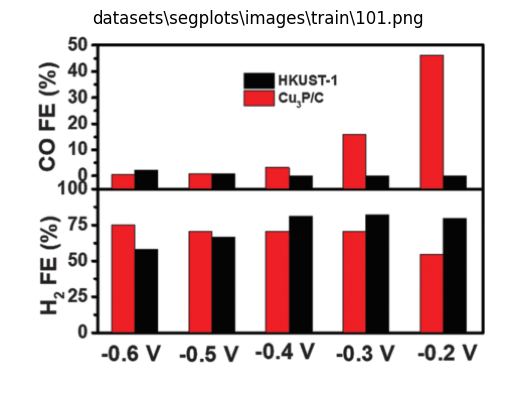

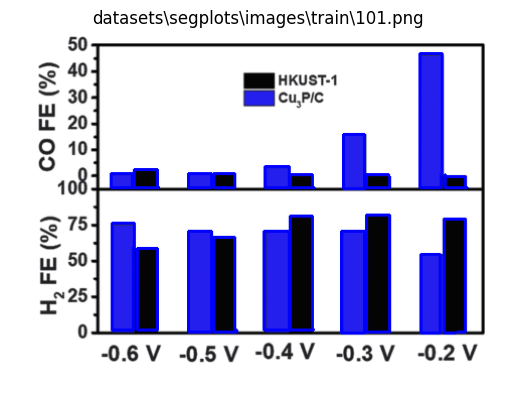

In [6]:
# loads and displays an image with the segmentation
import cv2
import matplotlib.pyplot as plt
import numpy as np

def display_image(image, seg_file):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(image)
    plt.axis('off')
    plt.show()

    with open(seg_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_index = int(parts[0])
            coordinates = list(map(float, parts[1:]))

            # Draw the segmentation mask
            points = [(coordinates[i], coordinates[i + 1]) for i in range(0, len(coordinates), 2)]
            points = np.array(points) * [img.shape[1], img.shape[0]]  # Denormalize coordinates
            points = points.astype(np.int32)
            cv2.polylines(img, [points], isClosed=True, color=(255, 0, 0), thickness=2)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(image)
        plt.axis('off')
        plt.show()

import time
random_src = npr.RandomState(int(time.time()))

# display the first image with the segmentation
sample_index = random_src.randint(0, len(os.listdir(path_to_train_images)))
image = os.path.join(path_to_train_images, os.listdir(path_to_train_images)[sample_index])
seg_file = os.path.join(path_to_train_labels, os.listdir(path_to_train_labels)[sample_index])
display_image(image, seg_file)


In [ ]:
# load the training configuration and start training
from ultralytics import YOLO
model = YOLO("yolo11n-seg.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="segplots.yaml", epochs=47, imgsz=640)

Ultralytics 8.3.27  Python-3.11.0 torch-2.4.1+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
engine\trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=segplots.yaml, epochs=47, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning F:\codes\maskksam1\datasets\segplots\labels\train.cache... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<?, ?it/s]
val: Scanning F:\codes\maskksam1\datasets\segplots\labels\val.cache... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<?, ?it/s]

Plotting labels to runs\segment\train7\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\segment\train7
Starting training for 47 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/47         0G      2.567      4.262      3.471      2.103         21        640: 100%|██████████| 3/3 [00:10<00:00,  3.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all          8         63    0.00791      0.302     0.0118    0.00636    0.00579      0.213    0.00913    0.00529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/47         0G      2.082      2.883      3.461      1.652         43        640: 100%|██████████| 3/3 [00:09<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all          8         63     0.0104      0.398     0.0412     0.0184    0.00757       0.28      0.025     0.0147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/47         0G      2.013      2.706      3.257      1.665         32        640: 100%|██████████| 3/3 [00:09<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all          8         63     0.0125      0.479     0.0654     0.0347     0.0101      0.373     0.0471     0.0202



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/47         0G      1.589      1.944      3.051      1.291         50        640: 100%|██████████| 3/3 [00:09<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all          8         63     0.0143      0.546      0.245      0.125     0.0106      0.405      0.189     0.0545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/47         0G      1.458      1.828      2.847      1.253         23        640: 100%|██████████| 3/3 [00:09<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all          8         63      0.013      0.494      0.238      0.114     0.0125      0.474      0.232     0.0704



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/47         0G      1.355      1.546      2.707      1.228         22        640: 100%|██████████| 3/3 [00:09<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all          8         63     0.0151      0.575      0.289       0.11     0.0128      0.489       0.17     0.0543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/47         0G      1.393      1.357      2.636      1.231         19        640: 100%|██████████| 3/3 [00:09<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all          8         63     0.0159      0.604      0.366      0.165     0.0122      0.467      0.176     0.0797



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/47         0G      1.311      2.179      2.373      1.181         10        640: 100%|██████████| 3/3 [00:09<00:00,  3.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

                   all          8         63      0.016      0.604      0.288      0.141     0.0107      0.415      0.158     0.0672



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/47         0G      1.318       1.26      2.455      1.271         29        640: 100%|██████████| 3/3 [00:08<00:00,  2.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all          8         63     0.0143      0.538      0.223       0.11     0.0109       0.42       0.14     0.0485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/47         0G      1.268      1.366      2.342      1.199         17        640: 100%|██████████| 3/3 [00:09<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all          8         63     0.0145      0.541      0.218      0.133     0.0119      0.454      0.188     0.0581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/47         0G       1.25      1.576      2.151      1.133         21        640: 100%|██████████| 3/3 [00:09<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all          8         63      0.017      0.627      0.242      0.118     0.0136      0.509      0.247     0.0916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/47         0G      1.593      1.459      2.153      1.308         32        640: 100%|██████████| 3/3 [00:09<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all          8         63     0.0173      0.641      0.273      0.143     0.0136      0.509      0.292      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/47         0G      1.396      1.184      2.035      1.266         16        640: 100%|██████████| 3/3 [00:09<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all          8         63     0.0164      0.607      0.342      0.172     0.0127      0.474       0.28      0.163



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/47         0G      1.362      1.087       1.93      1.276         24        640: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all          8         63      0.017      0.619      0.305      0.179     0.0115      0.437       0.25      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/47         0G      1.297      1.319      1.876      1.153         33        640: 100%|██████████| 3/3 [00:09<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all          8         63     0.0184      0.666      0.348      0.209     0.0103      0.412      0.212      0.134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/47         0G      1.099      1.181      1.806      1.149         14        640: 100%|██████████| 3/3 [00:09<00:00,  3.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all          8         63     0.0183      0.678      0.368      0.222     0.0118      0.461      0.185      0.122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/47         0G      1.307      1.229      1.561      1.171         42        640: 100%|██████████| 3/3 [00:09<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all          8         63      0.799      0.207      0.363      0.209      0.525     0.0172      0.207      0.133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/47         0G      1.263      1.307      1.396      1.163         50        640: 100%|██████████| 3/3 [00:09<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all          8         63      0.799      0.155      0.374      0.217      0.627      0.069      0.231      0.139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/47         0G      1.245      1.441      1.496      1.188         25        640: 100%|██████████| 3/3 [00:09<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all          8         63       0.84      0.221      0.404      0.231      0.575      0.143       0.26      0.148



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/47         0G      1.147       1.15      1.359      1.142         35        640: 100%|██████████| 3/3 [00:09<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all          8         63       0.75      0.244      0.408      0.237      0.523      0.356      0.294      0.163



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/47         0G      1.269      1.324      1.411      1.131         32        640: 100%|██████████| 3/3 [00:09<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all          8         63      0.657      0.267      0.418      0.256      0.556      0.112      0.356      0.198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/47         0G      1.253      1.529      1.386      1.145         38        640: 100%|██████████| 3/3 [00:09<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all          8         63      0.636      0.271      0.456      0.288      0.557      0.136      0.365      0.211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/47         0G      1.231        1.1      1.426      1.185         22        640: 100%|██████████| 3/3 [00:09<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all          8         63       0.64      0.314      0.453      0.295      0.565      0.186      0.341        0.2



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/47         0G      1.302      1.182      1.395      1.159         33        640: 100%|██████████| 3/3 [00:09<00:00,  3.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all          8         63      0.629      0.389      0.448      0.299      0.525      0.193      0.333      0.211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/47         0G      1.303      1.376        1.5      1.187         68        640: 100%|██████████| 3/3 [00:09<00:00,  3.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all          8         63      0.579      0.382       0.44      0.302      0.511      0.177      0.337       0.21



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/47         0G      1.045       1.15       1.25      1.047         19        640: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all          8         63      0.572      0.421      0.475      0.317      0.525      0.266      0.371      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/47         0G        1.1      1.046       1.34      1.063         27        640: 100%|██████████| 3/3 [00:09<00:00,  3.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all          8         63      0.515      0.421      0.459      0.321      0.478      0.319      0.382      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/47         0G      1.167      1.155       1.13      1.122         36        640: 100%|██████████| 3/3 [00:09<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all          8         63      0.499      0.424      0.414      0.293      0.445      0.344      0.343      0.169



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/47         0G      1.165      1.205      1.428      1.154         14        640: 100%|██████████| 3/3 [00:09<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all          8         63      0.499      0.424      0.414      0.293      0.445      0.344      0.343      0.169



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/47         0G      1.177      1.287      1.299      1.116         37        640: 100%|██████████| 3/3 [00:09<00:00,  3.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all          8         63      0.449      0.435      0.417      0.291      0.426      0.386      0.382      0.177



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/47         0G      1.081      1.016      1.194      1.105         35        640: 100%|██████████| 3/3 [00:09<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all          8         63       0.56      0.477      0.466      0.323      0.494      0.412      0.399      0.195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/47         0G      1.186        1.1      1.312      1.179         17        640: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all          8         63      0.549      0.489      0.461       0.34      0.511       0.42      0.423      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/47         0G      1.142      0.842      1.349       1.15         10        640: 100%|██████████| 3/3 [00:09<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all          8         63      0.549      0.489      0.461       0.34      0.511       0.42      0.423      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/47         0G      1.051     0.8997      1.152      1.063         27        640: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all          8         63      0.557      0.489      0.473      0.348      0.538      0.489       0.46      0.274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/47         0G     0.9912     0.8481      1.297      1.021          9        640: 100%|██████████| 3/3 [00:09<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all          8         63      0.546      0.485       0.49      0.376      0.553      0.521      0.499      0.298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/47         0G      1.142      1.231      1.247      1.124         59        640: 100%|██████████| 3/3 [00:09<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all          8         63      0.559      0.518      0.498      0.375      0.542       0.57      0.494      0.287



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/47         0G      1.039      0.963      1.145      1.089         20        640: 100%|██████████| 3/3 [00:09<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all          8         63      0.559      0.518      0.498      0.375      0.542       0.57      0.494      0.287


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/47         0G      1.153      1.241      1.377       1.13         43        640: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all          8         63       0.53      0.522      0.486      0.376      0.534       0.54       0.48      0.287



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/47         0G      1.064     0.8211      1.393      1.108          8        640: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all          8         63      0.548      0.544      0.483      0.365       0.53      0.523       0.47      0.271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/47         0G      1.107     0.8596      1.523      1.267          7        640: 100%|██████████| 3/3 [00:08<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all          8         63      0.534      0.547      0.477      0.361      0.482      0.436      0.457      0.264



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/47         0G     0.9844     0.8848      1.205      1.039         16        640: 100%|██████████| 3/3 [00:08<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all          8         63      0.534      0.547      0.477      0.361      0.482      0.436      0.457      0.264



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/47         0G      1.213     0.8742      1.426      1.109         24        640: 100%|██████████| 3/3 [00:08<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all          8         63      0.509      0.548      0.476      0.358      0.537      0.373      0.452      0.282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/47         0G      1.208      0.757      1.396      1.271         10        640: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all          8         63      0.507      0.551      0.482      0.362      0.462      0.434      0.458      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/47         0G     0.9909     0.8723      1.374       1.15         30        640: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all          8         63      0.513      0.553      0.488      0.363      0.477      0.471      0.462      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/47         0G      1.162       1.56      1.254      1.077          9        640: 100%|██████████| 3/3 [00:08<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all          8         63      0.513      0.553      0.488      0.363      0.477      0.471      0.462      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/47         0G      1.049      0.781      1.207      1.082          8        640: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all          8         63      0.526      0.549      0.498      0.368      0.502      0.517      0.474      0.284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/47         0G      0.862     0.8387      1.241      1.003         11        640: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all          8         63      0.557      0.538      0.513      0.378      0.505      0.549      0.478      0.292



47 epochs completed in 0.147 hours.
Optimizer stripped from runs\segment\train7\weights\last.pt, 6.0MB
Optimizer stripped from runs\segment\train7\weights\best.pt, 6.0MB

Validating runs\segment\train7\weights\best.pt...
Ultralytics 8.3.27  Python-3.11.0 torch-2.4.1+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
YOLO11n-seg summary (fused): 265 layers, 2,834,958 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


                   all          8         63      0.546      0.486       0.49      0.378      0.552      0.521      0.498      0.299
                  line          5         29      0.142      0.414      0.238      0.181      0.162      0.483       0.26     0.0991
                   bar          3         34       0.95      0.558      0.741      0.574      0.942      0.559      0.737      0.498
Speed: 0.8ms preprocess, 66.6ms inference, 0.0ms loss, 14.4ms postprocess per image
Results saved to runs\segment\train7


: 